# Airbnb (New York City) Price Prediction

*과제
- EDA
- 데이터 전처리
- 머신러닝(회귀) 모델을 학습하고, 예측  

*개요 
- 미국 NYC Airbnb 목록(2019)
- 프로젝트 목적: 가격 예측(price)
- 제공 데이터(3개): train.csv, test.csv, y_test(최종 채점용)
- 평가 방식: MSE (평균제곱오차/ 실제 값과 예측 값 차이 ->제곱해 평균)
- <참고> : 6. 지도학습(회귀) 노드의 6-8. 평가(회귀) 스텝에서 복습하실 수 있습니다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('/aiffel/data/train.csv')
test = pd.read_csv('/aiffel/data/test.csv')

# 1. EDA
## 데이터가 어떻게 생겼는지 살펴본다.

In [3]:
# 데이터 크기 (train 에는 target값이 하나 더 추가돼있어서 열이 하나 더 있음)
train.shape, test.shape

((39116, 16), (9779, 15))

In [4]:
# 데이터 샘플 (display를 쓰면 동시에 확인할 수 있다)
display(train.head(2))
display(test.head(2))

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,14963583,Room in South Harlem near Central Park,94219511,Gilles,Manhattan,Harlem,40.80167,-73.95781,Private room,70,3,3,2019-01-01,0.09,2,0
1,9458704,"Large 1BR Apartment, near Times Sq (2nd Floor)",49015331,Iradj,Manhattan,Hell's Kitchen,40.76037,-73.99016,Entire home/apt,240,2,64,2019-06-30,1.68,2,262


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,30913224,"Cozy and Sunny Room Williamsburg, Luxury Building",33771081,Rémy,Brooklyn,Williamsburg,40.70959,-73.94652,Private room,3,2,2019-05-08,0.31,1,0
1,971247,Sunny Artist Live/Work Apartment,5308961,Larry,Manhattan,Upper West Side,40.79368,-73.96487,Entire home/apt,3,159,2019-07-03,2.09,1,244


## 데이터별 수치형/ 범주형 데이터 종류를 확인한다

In [5]:
# 데이터 타입
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39116 entries, 0 to 39115
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39116 non-null  int64  
 1   name                            39104 non-null  object 
 2   host_id                         39116 non-null  int64  
 3   host_name                       39099 non-null  object 
 4   neighbourhood_group             39116 non-null  object 
 5   neighbourhood                   39116 non-null  object 
 6   latitude                        39116 non-null  float64
 7   longitude                       39116 non-null  float64
 8   room_type                       39116 non-null  object 
 9   price                           39116 non-null  int64  
 10  minimum_nights                  39116 non-null  int64  
 11  number_of_reviews               39116 non-null  int64  
 12  last_review                     

In [6]:
train.select_dtypes(include=['int64', 'float64']).columns

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [7]:
train.select_dtypes(include=['object']).columns

Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'last_review'],
      dtype='object')

> 여기서 last_review 데이터를 가지고, 최근 리뷰가 있으면 가격이 더 높다, 이런 식으로 연결지을 수 있을 거 같지만, 결측치가 너무 많아 제외해버리는 칼럼이 되었다.

## 데이터에 결측치가 있는지 확인해보는데, 있다. 처리해준다.

In [8]:
# 결측치(train)
train.isnull().sum()

id                                   0
name                                12
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       7994
reviews_per_month                 7994
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [9]:
# 결측치(test)
test.isnull().sum()

id                                   0
name                                 4
host_id                              0
host_name                            4
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       2058
reviews_per_month                 2058
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [10]:
# 결측치 컬럼 삭제(last_review)
train.drop(['id', 'name', 'host_name','last_review'], axis=1, inplace=True)
test.drop(['id', 'name', 'host_name','last_review'], axis=1, inplace=True)

In [11]:
# 결측치 채우기
train['reviews_per_month'] = train['reviews_per_month'].fillna(0)
test['reviews_per_month'] = test['reviews_per_month'].fillna(0)

In [12]:
train.dropna(how='any', inplace=True)
train.dropna(how='any', inplace=True)

## 가격의 분포는 아래와 같다. 매우 한쪽으로 치우쳐있다. 이것도 로그처리 해주자.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

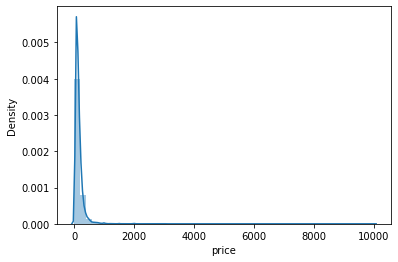

In [13]:
# target(hist)
sns.distplot(train['price'], kde=True, bins=50)

In [14]:
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

Skewness: 19.428985
Kurtosis: 597.221101


- Skewness = 0: Then normally distributed.
- Skewness > 0: Then more weight in the left tail of the distribution.
- Skewness < 0: Then more weight in the right tail of the distribution.

In [15]:
# target(describe)
train['price'].describe()

count    39116.000000
mean       152.751150
std        241.752501
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [16]:
# 피처(host_id)
train['host_id'].value_counts()

219517861    256
107434423    181
30283594      99
137358866     82
12243051      80
            ... 
73369106       1
26620387       1
176660539      1
26004891       1
2609535        1
Name: host_id, Length: 30845, dtype: int64

In [17]:
train.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

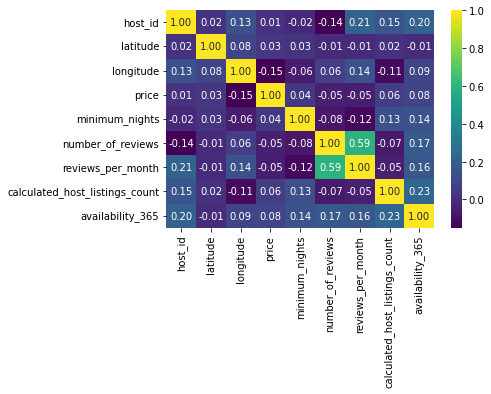

In [18]:
#크게 관련있어 보이는 애가 없다

corr_df = train.corr()
sns.heatmap(corr_df, annot= True, fmt='.2f', cmap='viridis')
train.columns

### 수치형 피처는 이런 게 남았다

In [19]:
num_col = train.select_dtypes(include=['int64', 'float64']).columns

### 범주형 데이터에는 이런게 있다. 얘네는 이따가 레이블인코딩을 해준다

In [20]:
cat_col = train.select_dtypes(include=['object']).columns

In [21]:
train.shape, test.shape

((39116, 12), (9779, 11))

# Visualization

In [22]:
train['neighbourhood_group'].unique()

array(['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'Staten Island'],
      dtype=object)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Neighbourhood Group')

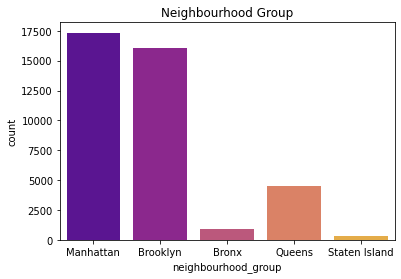

In [23]:
sns.countplot(train['neighbourhood_group'], palette='plasma')
plt.title('Neighbourhood Group')

Text(0, 0.5, 'count')

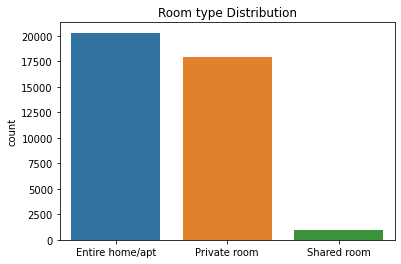

In [24]:
sns.barplot(x=train['room_type'].value_counts().index , y=train['room_type'].value_counts()).set(title='Room type Distribution')
plt.ylabel('count')

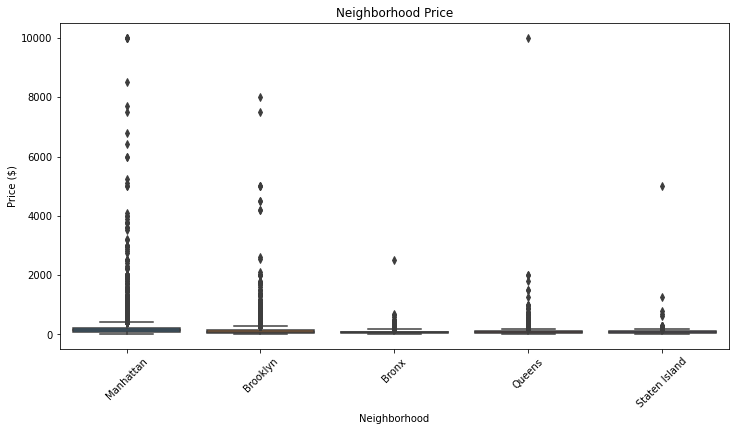

In [25]:
#Neighbourhood별 가격

plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=train)
plt.xticks(rotation=45)  # x 축 라벨 회전
plt.title('Neighborhood Price')
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.show();

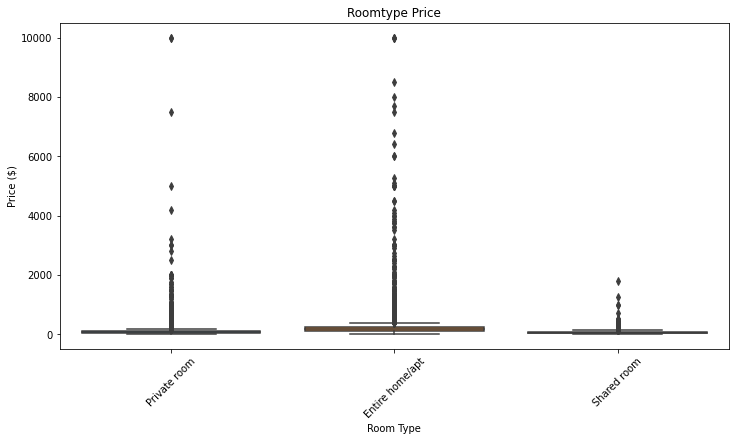

In [26]:
#Roomtype별 가격

plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=train)
plt.xticks(rotation=45)  # x 축 라벨 회전
plt.title('Roomtype Price')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show();

In [27]:
from wordcloud import WordCloud

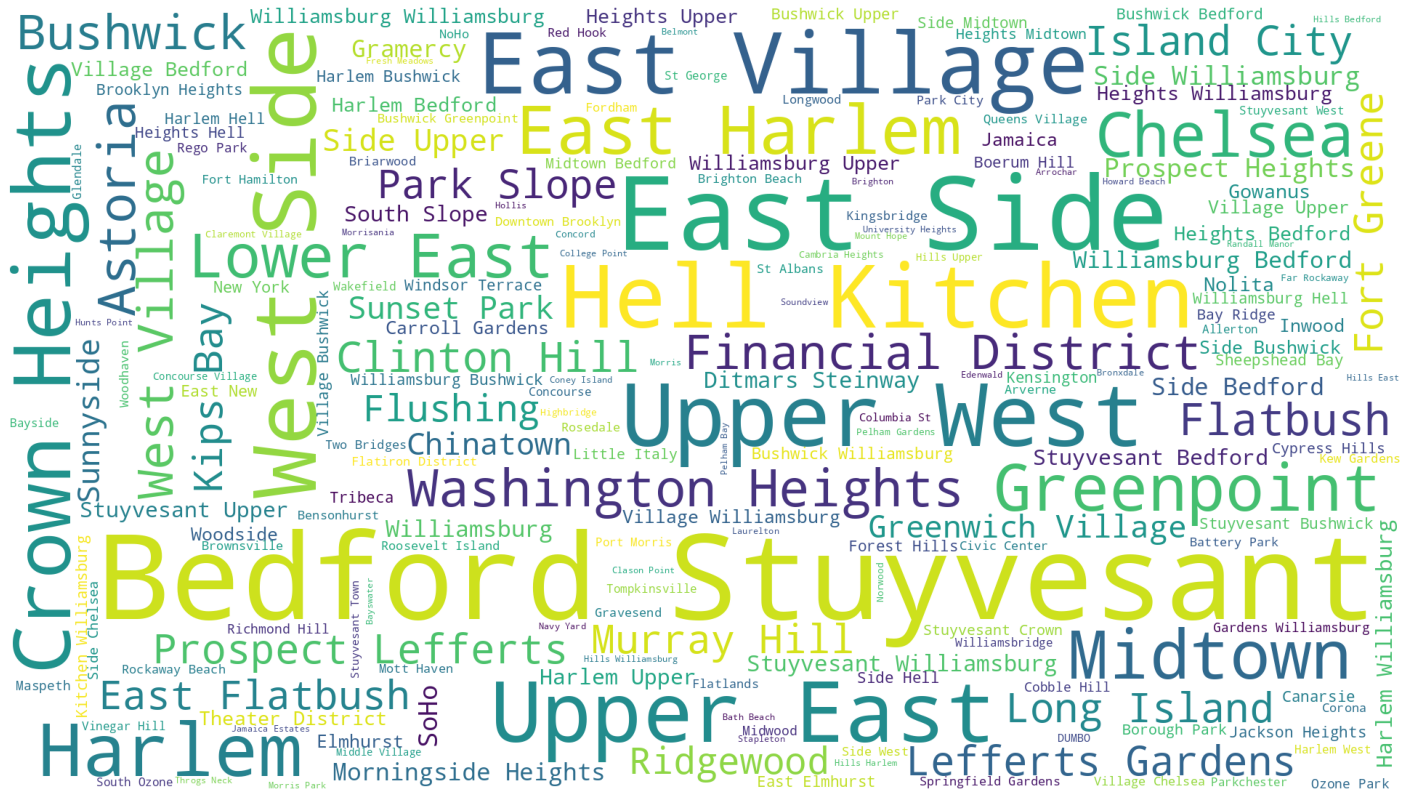

In [28]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(train.neighbourhood))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('neighbourhood.png')
plt.show()

## 3) 수치 데이터 정규화
- 일단 수치화데이터들의 price와의 관계를 확인

## Price

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


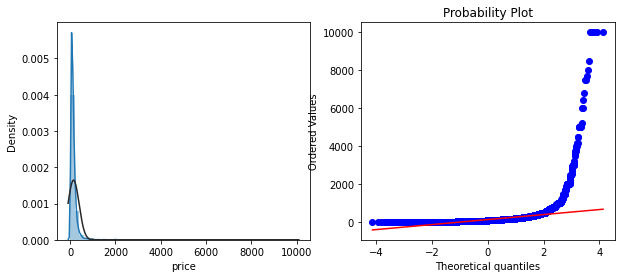

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
ax1= sns.distplot(train['price'], fit=norm, ax=axes[0])
ax2 = stats.probplot(train['price'], plot=axes[1])

In [30]:
train['price'] = np.log1p(train['price'])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


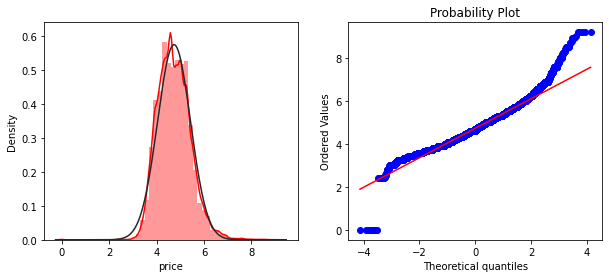

In [31]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
ax1= sns.distplot(train['price'], fit=norm, ax=axes[0], color ='red')
ax2 = stats.probplot(train['price'], plot=axes[1])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


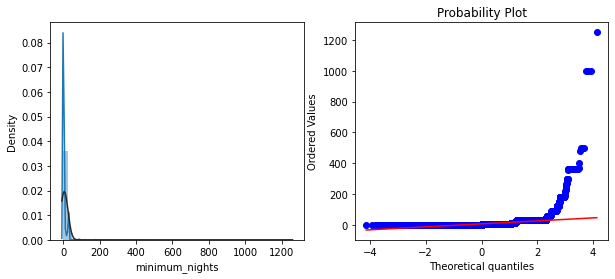

In [32]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
ax1= sns.distplot(train['minimum_nights'], fit=norm, ax=axes[0])
ax2 = stats.probplot(train['minimum_nights'], plot=axes[1])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


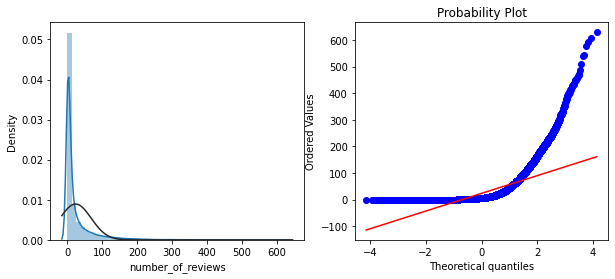

In [33]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
ax1= sns.distplot(train['number_of_reviews'], fit=norm, ax=axes[0])
ax2 = stats.probplot(train['number_of_reviews'], plot=axes[1])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


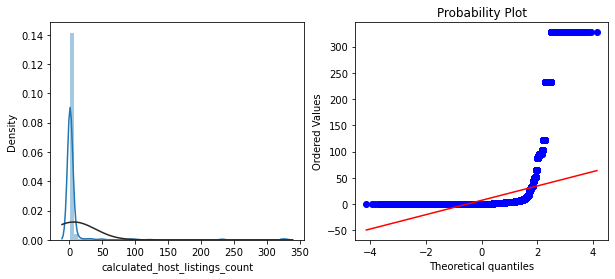

In [34]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
ax1= sns.distplot(train['calculated_host_listings_count'], fit=norm, ax=axes[0])
ax2 = stats.probplot(train['calculated_host_listings_count'], plot=axes[1])

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


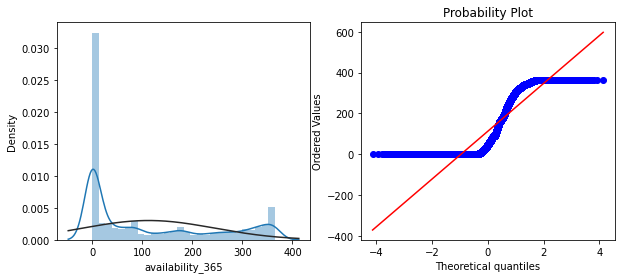

In [35]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
ax1= sns.distplot(train['availability_365'], fit=norm, ax=axes[0])
ax2 = stats.probplot(train['availability_365'], plot=axes[1])

## 3)범주형 데이터 (레이블 인코딩)

In [36]:
train.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,94219511,Manhattan,Harlem,40.80167,-73.95781,Private room,4.262680,3,3,0.09,2,0
1,49015331,Manhattan,Hell's Kitchen,40.76037,-73.99016,Entire home/apt,5.484797,2,64,1.68,2,262
2,440022,Manhattan,West Village,40.73001,-74.00562,Entire home/apt,5.017280,60,1,0.20,1,0
3,3577509,Brooklyn,Bedford-Stuyvesant,40.69128,-73.93653,Entire home/apt,4.454347,4,239,2.89,2,1
4,12475280,Brooklyn,Bedford-Stuyvesant,40.68899,-73.95555,Private room,3.806662,28,0,0.00,1,0


In [37]:
# train.drop(['host_id','latitude','longitude'], axis=1, inplace=True)
# test.drop(['host_id','latitude','longitude'], axis=1, inplace=True)

train.drop('host_id', axis=1, inplace=True)
test.drop('host_id', axis=1, inplace=True)

In [38]:
train.shape, test.shape

((39116, 11), (9779, 10))

In [39]:
train.select_dtypes(include=['object']).columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cols = ['neighbourhood_group', 'neighbourhood', 'room_type']

for col in cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [41]:
train.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2,94,40.80167,-73.95781,1,4.262680,3,3,0.09,2,0
1,2,95,40.76037,-73.99016,0,5.484797,2,64,1.68,2,262
2,2,209,40.73001,-74.00562,0,5.017280,60,1,0.20,1,0


In [42]:
train['price'] = np.expm1(train['price'])

In [43]:
train.shape, test.shape

((39116, 11), (9779, 10))

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

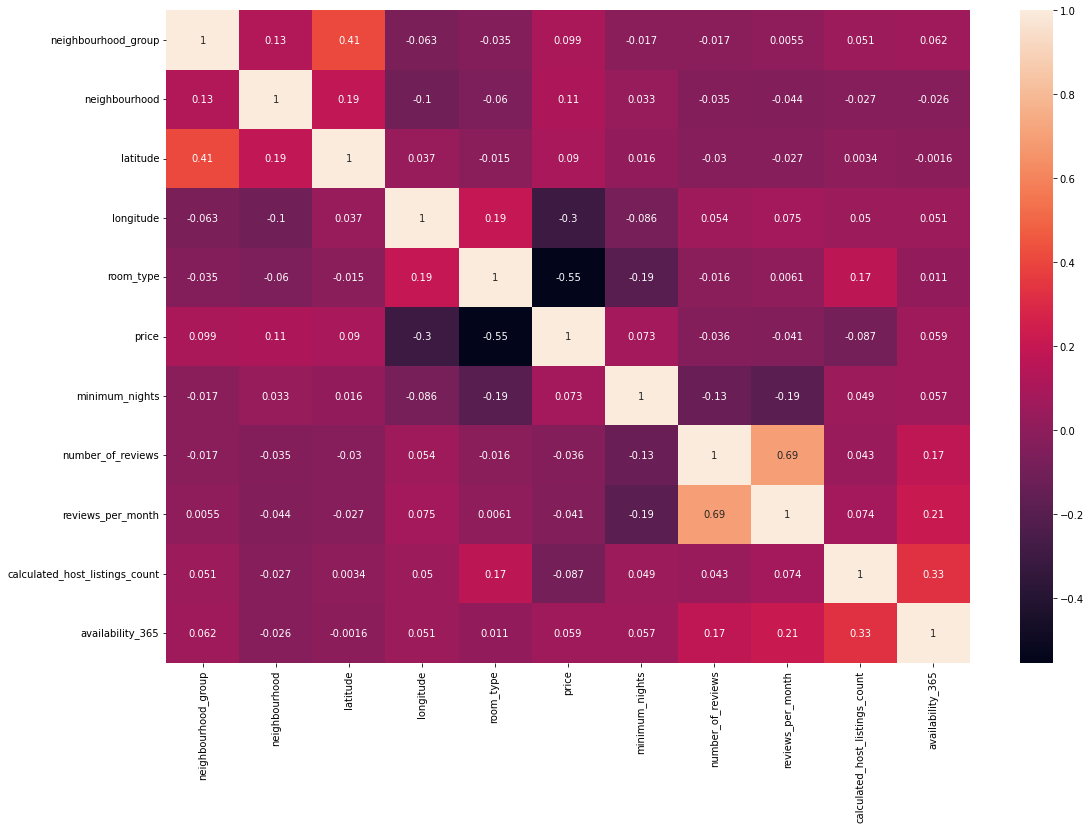

In [44]:
corr = train.corr(method='kendall')
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True)
train.columns

# 3. 검증데이터 분리 
- Train 데이터만 가지고 학습
- Validation 데이터 나눠서 예측

In [45]:
#검증용 데이터 분리
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [46]:
#검증용 데이터 분리하는 코드 (train_test_split) (여기서 test가 곧 validation이라서 헷갈린거다)

X_train, X_val, y_train, y_val = train_test_split(
    train.drop('price',axis=1), train['price'], test_size=0.2, random_state=2022)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((31292, 10), (7824, 10), (31292,), (7824,))

## 1) 선형회귀

In [47]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)
pred = model.predict(X_val)

#평가 mse로 해보기 (작을수록 좋다)
mean_squared_error(y_val, pred)

29210.072025519297

## 2) 릿지회귀

In [48]:
from sklearn.linear_model import Ridge
model = Ridge()

model.fit(X_train, y_train)
pred = model.predict(X_val)

mean_squared_error(y_val, pred)

29212.084466689805

## 3) 라쏘회귀

In [49]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=1)

model.fit(X_train, y_train)
pred = model.predict(X_val)

mean_squared_error(y_val, pred)

29858.342868794647

## 4) 엘라스틱넷 회귀

In [50]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1)

model.fit(X_train, y_train)
pred = model.predict(X_val)

mean_squared_error(y_val, pred)

31317.84623608296

## 5) 랜덤 포레스트

In [51]:
from sklearn.ensemble import RandomForestRegressor
model_r = RandomForestRegressor(random_state=2022)

model_r.fit(X_train, y_train)
pred_r = model_r.predict(X_val)

mean_squared_error(y_val, pred_r)

31495.413508282214

## 6) XGBoost

In [52]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=2022)

model.fit(X_train, y_train)
pred = model.predict(X_val)

mean_squared_error(y_val, pred)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


29603.28926471407

## XGBoost에 하이퍼파라미터 적용

In [53]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [64]:
xgb = XGBRegressor()

params = {'learning_rate':[0.07, 0.05],
         'max_depth':[3,5,7],
         'n_estimators':[100, 200],
         'subsample':[0.9, 0.8, 0.7]}


grid = RandomizedSearchCV(xgb, params, cv=3, n_iter=10, n_jobs=-1) 
grid.fit(X_train, y_train)
pred = grid.predict(X_val)


# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid.best_params_)

Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.07}


In [65]:
xgb = XGBRegressor(
    learning_rate = 0.07,
    max_depth = 7,
    n_estimators = 200,
    subsample = 0.8)

xgb.fit(X_train, y_train)
pred_x = xgb.predict(X_val)
mean_squared_error(y_val, pred_x)

28561.719695183834

# 💡 최종 테스트

In [66]:
# test 데이터 예측 및 평가
y_test = pd.read_csv('/aiffel/data/y_test.csv')

# Xgboost
pred = xgb.predict(test)
mean_squared_error(y_test, pred)

50425.81293661643

# 회고
1. 마지막에 헤맸는데, 그 이유가 price만 log를 취해주고, 다른 수치형 데이터들은 로그를 취해주지 않았기 때문에 꼬여서 mse가 7만이 넘게 나오고 이랬다. 그래서 왜 데이터를 더 만졌더니 오차가 극심해졌나(?)를 머리를 쥐어싸고 고민하다가 깨달았다. 할거면 다 해줘야되나보다. 
2. EDA는 재미있다. 수치형/범주형 데이터를 확인하고, 어떤 데이터가 target값에 유의미한 영향을 끼칠지 탐색하는 과정이 재미있다. 
3. 같은 Airbnb 캐글 데이터를 가지고, 잘한 사람들 코드 필사를 해보면서 machine learning flow를 더 숙지해야겠다. validation 이랑 test라는 용어가 종종 혼용되어 사용되기 때문에 헷갈리기 쉽다는 것도 배웠다. '데이터를 도대체 몇 번을 쪼개는거야' 하면서 혼돈으 카오스에 빠졌는데, 이제 좀 감이 잡힌다.
4. train, validation, test로 나누고 / train,test 데이터를 먼저 전처리를 동일하게 진행해주어야 하고 / train 데이터를 X,y, train, validation데이터로 총 4개로 쪼개서 / 그걸 가지고 모델에 fit, transform, predict를 해서 모델이 잘 생겨먹었는지 확인해주고 / 그 다음 최종적으로 test 데이터를 가지고 모델을 돌려봐서 최종적으로 값을 잘 예측하는지 확인한다. (따라서, test데이터에는 target열이 하나 빠져있다)
5. 그래도 찔끔(?) MSE가 더 내려갔다. 주말동안 파라미터를 어떻게 잘 engineering할 수 있을지 더 고민해보겠다.